# Statistical and Spatial Analysis of the Apartment Segment in the Spanish Real Estate Market (2019) - Geolocalization

#### Obtain the full address, region, province, city, and coordinates through geolocation and integration of external data.

For this process, we use the **geopy** library, a Python client for several popular geocoding web services. To have this library available, we need to install it via **pip** in the Bash terminal or directly in a Jupyter Notebook cell.

```python
    pip install geopy
```

Import the geocoder to be used; in this case, we will use **Nominatim**, an Open Source geolocator that utilizes OpenStreetMap.



In [8]:
# Import libraries
import requests
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the geocoder
from geopy.geocoders import Nominatim

# Error handling
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

#### Split the dataframe into chunks to optimize memory and execution time.

Given the file’s size, geolocating all entries at once would be inefficient and could lead to memory issues and very high processing time. To mitigate this, the file is **divided into chunks of 10,000 rows**. The create_chunks function is designed to split the DataFrame, save each chunk to disk, and generate a list of the file names.

In [3]:
def create_chunks(df, chunksize, directory):
    file_names = []
    chunk_number = 0

    # Iterar sobre el DataFrame en trozos de tamaño específico
    for start in range(0, len(df), chunksize):
        chunk_number += 1
        chunk = df[start:start + chunksize]
        # Guardar el chunk en un archivo CSV
        file_name = f'{directory}/dataframe_{chunk_number}.csv'
        chunk.to_csv(file_name, index=False)
        file_names.append(file_name)
        # Liberar memoria
        del chunk
        gc.collect()

    return file_names

In [2]:
def create_chunks(df, chunksize, directory):
    file_names = []
    chunk_number = 0

    # Iterar sobre el DataFrame en trozos de tamaño específico
    for start in range(0, len(df), chunksize):
        chunk_number += 1
        chunk = df[start:start + chunksize]
        # Guardar el chunk en un archivo CSV
        file_name = f'{directory}/dataframe_{chunk_number}.csv'
        chunk.to_csv(file_name, index=False)
        file_names.append(file_name)
        # Liberar memoria
        del chunk
        gc.collect()

    return file_names

#### Declare variables and execute functions

In [10]:
# Output directory
directory = 'data/'

# Input File
df = pd.read_csv('data/clean_data.csv')

# Chunks Size
chunksize = 10000

# chunks_files = create_chunks(input_csv, chunksize, directory)
# print(chunks_files)

#### Obtaining Latitude and Longitude

The **geolocate** function takes the full address from the `loc_full` variable, attempts to geocode it, and returns the latitude and longitude. If there is an issue, it will try with the `city_prov` variable, which only includes the city and province. It will return `None` if neither of the two variables is successful. Between each iteration with the geolocator, it will wait for 1 second, which is the minimum time for each request with this geolocator. The function includes:

- A loop to retry geolocation up to a maximum number of retries.
- A 10-second timeout for each geolocation attempt, as set in the **geopy** configuration.
- Error handling that includes a `time.sleep` with a `backoff_factor` to increase the wait time between retries.

In [ ]:
def geolocate(row, geolocator, retries=retries, backoff_factor=backoff_factor, timeout=timeout):
    address = row['loc_full']
    address_2 = row['city_prov']

    for attempt in range(retries):
        try:
            location = geolocator.geocode(address, timeout=timeout)
            if not location:
                time.sleep(1)
                location = geolocator.geocode(address_2, timeout=timeout)

            if location:
                return pd.Series([location.latitude, location.longitude, location.address])
            else:
                return pd.Series([None, None, None])
        except (GeocoderTimedOut, GeocoderServiceError) as e:
            print(f"Error geocoding {address} or {address_2}: {e}")
            time.sleep(backoff_factor * (2 ** attempt))
    return pd.Series([None, None, None])

The **split_address** function extracts the `postal code`, `region`, and `municipality` from the address provided by the geolocation.

In [5]:
def split_address(df, address_col):
    df = df.copy()
    p_codes = []
    regions = []
    municipalities = []

    for address in df[address_col]:
        if address:
            parts = address.split(', ')
            if len(parts) >= 3:
                possible_p_code = parts[-2]

                if len(possible_p_code) == 5 and possible_p_code.isdigit():
                    p_code = possible_p_code
                    region = parts[-3]
                    municipality = parts[-4]
                else:
                    p_code = None
                    region = parts[-2]
                    municipality = parts[-3]
            else:
                p_code = None
                region = None
                municipality = None
        else:
            p_code = None
            region = None
            municipality = None

        p_codes.append(p_code)
        regions.append(region)
        municipalities.append(municipality)

    df['p_code'] = p_codes
    df['region'] = regions
    df['municipality'] = municipalities

    return df

The **process_chunk** function generates the new data columns created with **geolocate** and **split_address** function and adds them to the section of the dataframe being processed, then saves it to a CSV file. It then frees the created dataframe from memory and forces garbage collection. This method ensures that the memory used by the dataframe is released after saving, helping to maintain efficient memory usage when processing large volumes of data.

In [7]:
def process_chunk(chunk_file, directory, geolocator):
    df_chunk = pd.read_csv(chunk_file)
    location_data = []

    for idx, row in df_chunk.iterrows():
        location_data.append(geolocate(row, geolocator))
        time.sleep(1)
    df_chunk[['latitude', 'longitude', 'address']] = pd.DataFrame(location_data)
    df_chunk = split_address(df_chunk, 'address')

    # Save dataframe
    processed_file_name = f'{directory}/processed_{chunk_file.split("/")[-1]}'
    df_chunk.to_csv(processed_file_name, index=False)

    # Free memory
    del df_chunk
    gc.collect()

    return processed_file_name

#### Define Variables and Execute Functions

In [9]:
# Define geolocator
# geolocator = Nominatim(user_agent="spanish_houses")

# Funtions parameters
retries = 3
backoff_factor = 0.3
timeout = 10

# Define variables
directory = 'data/chunks/'

# Execute functions to obtain Latitude and Longitude
#  process_chunk('data/chunks/dataframe_1.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_2.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_3.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_4.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_5.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_6.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_7.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_8.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_9.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_10.csv', directory, geolocator)

### Saving Geolocalized Data

In [10]:
processed_files = ['data/chunks/processed_dataframe_1.csv',
                   'data/chunks/processed_dataframe_2.csv',
                   'data/chunks/processed_dataframe_3.csv',
                   'data/chunks/processed_dataframe_4.csv',
                   'data/chunks/processed_dataframe_5.csv',
                   'data/chunks/processed_dataframe_6.csv',
                   'data/chunks/processed_dataframe_7.csv',
                   'data/chunks/processed_dataframe_8.csv',
                   'data/chunks/processed_dataframe_9.csv',
                   'data/chunks/processed_dataframe_10.csv']

# dataframes = [pd.read_csv(file) for file in processed_files]
# processed_dataframe = pd.concat(dataframes, ignore_index=True)

# Save the dataframe
# processed_dataframe.to_csv('data/processed_dataframe.csv', index=False)

### Coordinate Fluctuation (Jittering)

In [13]:
def move_coordinates(lat, lon, distance, angle):
    """
    Moves the coordinates by a specified distance and angle.
    The distance is given in meters and the angle in degrees.
    """
    # Radius of the earth in meters.
    R = 6378137.0

    # Convert distance from meters to degrees.
    delta_lat = distance / R
    delta_lon = distance / (R * np.cos(np.pi * lat / 180))

    # Convert the angle to radians.
    theta = np.radians(angle)

    new_lat = lat + delta_lat * np.sin(theta) * (180 / np.pi)
    new_lon = lon + delta_lon * np.cos(theta) * (180 / np.pi)

    return new_lat, new_lon

def disperse_coordinates(df, lat_col='latitude', lon_col='longitude', min_distance=10, max_distance=100):
    """
    Randomly disperse coordinates.
    """
    counts = df.groupby([lat_col, lon_col]).size().reset_index(name='counts')
    duplicates = counts[counts['counts'] > 1]

    for _, row in duplicates.iterrows():
        lat = row[lat_col]
        lon = row[lon_col]
        count = int(row['counts'])

        angles = np.random.uniform(0, 360, count)
        distances = np.random.uniform(min_distance, max_distance, count)

        idx = df[(df[lat_col] == lat) & (df[lon_col] == lon)].index
        for i, angle, distance in zip(idx, angles, distances):
            new_lat, new_lon = move_coordinates(lat, lon, distance, angle)
            df.at[i, lat_col] = float(new_lat)
            df.at[i, lon_col] = float(new_lon)

    return df

In [11]:
# Load the processed dataframe
processed_data = pd.read_csv('data/processed_dataframe.csv')

In [14]:
# Define parameters.
lat_col = 'latitude'
lon_col = 'longitude'
min_distance = 100
max_distance = 150
# Perform the Jittering
processed_data = disperse_coordinates(processed_data, lat_col, lon_col, min_distance, max_distance)

### Post-Geolocation Data Cleaning

#### Checking for Null Values

In [15]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89948 entries, 0 to 89947
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   air_conditioner  89948 non-null  int64  
 1   bath_num         89948 non-null  int64  
 2   chimney          89948 non-null  int64  
 3   condition        89948 non-null  object 
 4   garage           89948 non-null  object 
 5   garden           89948 non-null  int64  
 6   house_type       89948 non-null  object 
 7   m2_real          89948 non-null  int64  
 8   price            89948 non-null  float64
 9   room_num         89948 non-null  int64  
 10  storage_room     89948 non-null  int64  
 11  swimming_pool    89948 non-null  int64  
 12  terrace          89948 non-null  int64  
 13  latitude         89948 non-null  float64
 14  longitude        89948 non-null  float64
 15  address          89948 non-null  object 
 16  p_code           89948 non-null  int64  
 17  region      

#### Validating Coordenate Ranges

The valid coordinate ranges in Spain are:

- **Latitude**: Between 27.6°N (Canary Islands) and 43.8°N (northern Spain).
- **Longitude**: Between -18.2°W (Canary Islands) and 4.3°E (east of the Balearic Islands).

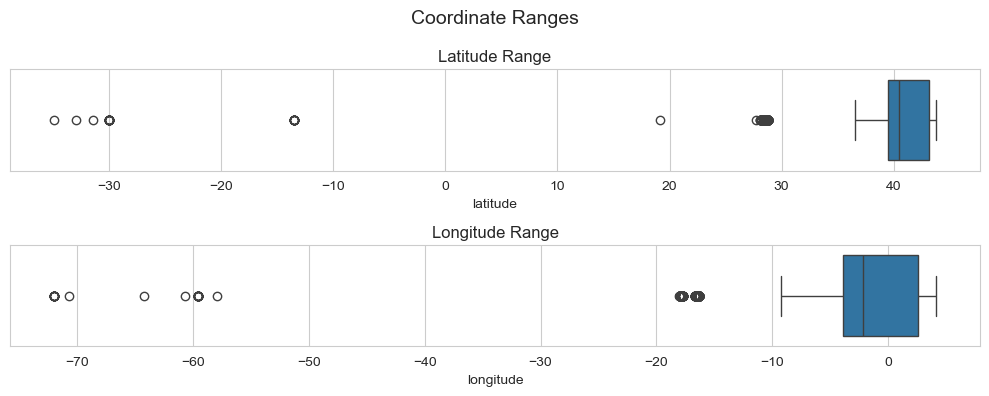

In [16]:
fig, ax = plt.subplots(2,1, figsize=(10, 4))

sns.boxplot(x=processed_data['latitude'], ax=ax[0])
ax[0].set_title('Latitude Range')

sns.boxplot(x=processed_data['longitude'], ax=ax[1])
ax[1].set_title('Longitude Range')

fig.suptitle('Coordinate Ranges', fontsize=14)
plt.tight_layout()
plt.show()

#### Remove Invalid Records

In [17]:
# Counting Invalid Records in longitude
outliers_longitude = processed_data[processed_data['longitude'] < -20.0]
count = outliers_longitude['longitude'].value_counts().sum()
print(f"The dataframe has {int(count)} longitude records out of range")

The dataframe has 37 longitude records out of range


In [18]:
# Remove records out of range (< -20.0)
processed_data = processed_data[processed_data['longitude'] >= -20]

In [19]:
# Verifying
print(f"Latitude: Min = {processed_data['latitude'].min()}, Max = {processed_data['latitude'].max()}")
print(f"Longitude: Min = {processed_data['longitude'].min()}, Max = {processed_data['longitude'].max()}")

Latitude: Min = 27.7254993, Max = 43.77288
Longitude: Min = -18.024301, Max = 4.111821376449803


In [15]:
## Save Dataframe
processed_data.to_csv('data/geolocated_data.csv', index=False)